In [1]:
import os

import pandas as pd

os.path.abspath(os.curdir)

'/Users/nicholsn/Repos/metasearch/crawler/load'

In [2]:
# Load all the transformed files into a dataframes to be merged.
load_path = os.path.abspath(os.curdir)
xfm_path = os.path.abspath('../transform')
project_names = [project for project in os.listdir(xfm_path) if '.' not in project]
csv_files = list()
for project_name in project_names:
    xfm_dir = os.path.join(xfm_path, project_name)
    files = os.listdir(xfm_dir)
    [csv_files.append(os.path.join(xfm_path, project_name, csv)) for csv in files if '.csv' in csv]

In [3]:
# Define the order of the columns we want in our final table.
columns = ['project',
           'site_id',
           'participant_id',
           'diagnosis',
           'sex', 
           'age',
           'handedness',
           'full iq',
           'performance iq',
           'verbal iq']

In [4]:
df_list = [pd.read_csv(i) for i in csv_files]
df = pd.concat(df_list)
df.to_csv(os.path.join(load_path, 'phenotype.csv'), columns=columns, index=False)
df.head()

,age,diagnosis,dsm_iv_tr,full iq,handedness,participant_id,performance iq,project,sex,site_id,verbal iq
0,16.77,autism,autism,103.0,ambidextrous,50002.0,89.0,abide_initiative,Male,university of pittsburg,116.0
1,24.45,autism,autism,124.0,right handed,50003.0,115.0,abide_initiative,Male,university of pittsburg,128.0
2,19.09,autism,autism,113.0,right handed,50004.0,117.0,abide_initiative,Male,university of pittsburg,108.0
3,13.73,autism,autism,119.0,right handed,50005.0,118.0,abide_initiative,Female,university of pittsburg,117.0
4,13.37,autism,autism,109.0,left handed,50006.0,119.0,abide_initiative,Male,university of pittsburg,99.0


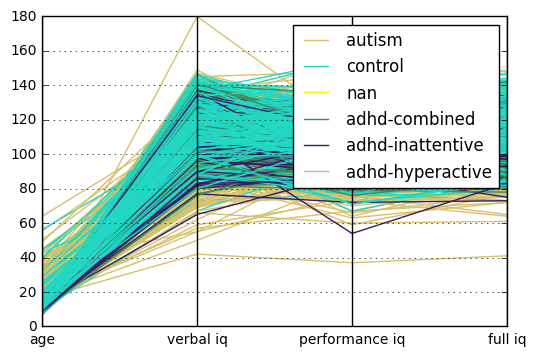

In [5]:
from matplotlib import pyplot as plt
pd.tools.plotting.parallel_coordinates(df, 'diagnosis', cols=['age', 'verbal iq', 'performance iq', 'full iq'])
plt.show()